In [1]:
#認証が必要
import os
import pandas as pd
import numpy as np

%tensorflow_version 1.x
import tensorflow as tf
tf.disable_v2_behavior()
print(tf.__version__)
import keras.backend as K

import scipy.io
from google.colab import drive

!apt-get update && apt-get install imagemagick
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

drive.mount('/content/drive/')

cwd = os.getcwd()
print(cwd)

#google driveのMy Drive内にあるinput.csvを選択
data_path = '/content/drive/My Drive/研究/Master/PINN/data/cylinder_nektar_wake.mat'

TensorFlow 1.x selected.
Instructions for updating:
non-resource variables are not supported in the long term
1.15.2


Using TensorFlow backend.


Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:12 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [8,507 B]
Get:13 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [912 kB]
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease

# モデル部分

In [0]:
np.random.seed(1234)
tf.set_random_seed(1234)

class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, y0, t0, u0, v0,
                 xb, yb, tb, ub, vb,
                 x, y, t,
                 layers,
                 p0=None, pb=None):
        """
        Arg:
            x0, y0, t0, u0, v0 : array(1d)
                初期条件の配列

            xb, yb, tb, ub, vb : array(1d)
                境界条件の配列

            x, y, t : array(1d)
                全点(meshgrid)

            layers : list
                隠れ層の次元
        """
        
        X = np.concatenate([x, y, t], axis=1)
        print(X.shape)
        X0 = np.concatenate([x0, y0, t0], axis=1)
        print(X0.shape)
        Xb = np.concatenate([xb, yb, tb], axis=1)
        print(Xb.shape)
        
        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X
        self.num = X.shape[0]
        
        # 入力パラ
        self.x = X[:,0:1]
        self.y = X[:,1:2]
        self.t = X[:,2:3]

        # 固定情報
        self.x0 = X0[:, 0:1]
        self.y0 = X0[:, 1:2]
        self.t0 = X0[:, 2:3]
        self.xb = Xb[:, 0:1]
        self.yb = Xb[:, 1:2]
        self.tb = Xb[:, 2:3]

        # p固定用
        self.p0 = p0
        self.pb = pb

        # for debug
        # random_idx = np.random.permutation(np.arange(0,self.num,1))[:1000]
        # self.x_all = self.x_all[random_idx,:]
        # self.y_all = self.y_all[random_idx,:]
        # self.t_all = self.t_all[random_idx,:]

        # 点単位でのloss計算用
        self.u0 = u0
        self.v0 = v0
        self.ub = ub
        self.vb = vb

        # 隠れ層
        self.layers = layers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)        
        
        # Initialize parameters
        self.lambda_1 = 1.00
        self.lambda_2 = 0.01
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        ## 初期条件
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.y0_tf = tf.placeholder(tf.float32, shape=[None, self.y0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.v0_tf = tf.placeholder(tf.float32, shape=[None, self.v0.shape[1]])
        
        ## 境界条件(とりあえず全部ごっちゃ)
        self.xb_tf = tf.placeholder(tf.float32, shape=[None, self.xb.shape[1]])
        self.yb_tf = tf.placeholder(tf.float32, shape=[None, self.yb.shape[1]])
        self.tb_tf = tf.placeholder(tf.float32, shape=[None, self.tb.shape[1]])
        self.ub_tf = tf.placeholder(tf.float32, shape=[None, self.ub.shape[1]])
        self.vb_tf = tf.placeholder(tf.float32, shape=[None, self.vb.shape[1]])
        ## PDE point
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        
        if (p0 is not None) & (pb is not None):
            self.p0_tf = tf.placeholder(tf.float32, shape=[None, self.p0.shape[1]])
            self.pb_tf = tf.placeholder(tf.float32, shape=[None, self.pb.shape[1]])
        # self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        # self.v_tf = tf.placeholder(tf.float32, shape=[None, self.v.shape[1]])
        
        # prediction
        ## 初期条件回り
        self.u0_pred, self.v0_pred, self.p0_pred = self.net_uv(self.x0_tf, self.y0_tf, self.t0_tf)
        ## 境界条件回り
        self.ub_pred, self.vb_pred, self.pb_pred = self.net_uv(self.xb_tf, self.yb_tf, self.tb_tf)
        self.u_pred, self.v_pred, self.p_pred, self.f_pred, self.g_pred, self.h_pred = self.net_NS(self.x_tf, self.y_tf, self.t_tf)
        if (p0 is None) & (pb is None):
            self.loss = \
                tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) \
                + tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) \
                + tf.reduce_mean(tf.square(self.ub_tf - self.ub_pred)) \
                + tf.reduce_mean(tf.square(self.vb_tf - self.vb_pred)) \
                + tf.reduce_mean(tf.square(self.f_pred))\
                + tf.reduce_mean(tf.square(self.g_pred))\
                + tf.reduce_mean(tf.square(self.h_pred))

        else:
            assert (p0 is not None) | (pb is not None), "err"
            self.loss = \
                tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) \
                + tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred)) \
                + tf.reduce_mean(tf.square(self.ub_tf - self.ub_pred)) \
                + tf.reduce_mean(tf.square(self.vb_tf - self.vb_pred)) \
                # + tf.reduce_mean(tf.square(self.f_pred))\
                # + tf.reduce_mean(tf.square(self.g_pred))\
                # + tf.reduce_mean(tf.square(self.h_pred))\
                # + tf.reduce_mean(tf.square(self.p0_tf - self.p0_pred)) \
                # + tf.reduce_mean(tf.square(self.pb_tf - self.pb_pred))


        
        self.loss_list = []


        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 5000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
        
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)             
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        # H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_uv(self, x, y, t):
        inputs = tf.concat([x,y,t], axis=1)
        out = self.neural_net(inputs, self.weights, self.biases)
        # TO DO : out = u,v,pのとき
        psi = out[:, 0:1]
        p = out[:, 1:2]

        u = tf.gradients(psi, y)[0]
        v = -tf.gradients(psi, x)[0]

        return u, v, p
        
    def net_NS(self, x, y, t):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        
        sess = tf.Session()

        u, v, p = self.net_uv(x, y, t)
        
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_y = tf.gradients(u, y)[0]
        u_xx = tf.gradients(u_x, x)[0]
        u_yy = tf.gradients(u_y, y)[0]
        
        v_t = tf.gradients(v, t)[0]
        v_x = tf.gradients(v, x)[0]
        v_y = tf.gradients(v, y)[0]
        v_xx = tf.gradients(v_x, x)[0]
        v_yy = tf.gradients(v_y, y)[0]
        
        p_x = tf.gradients(p, x)[0]
        p_y = tf.gradients(p, y)[0]

        f_u = u_t + lambda_1*(u*u_x + v*u_y) + p_x - lambda_2*(u_xx + u_yy) 
        f_v = v_t + lambda_1*(u*v_x + v*v_y) + p_y - lambda_2*(v_xx + v_yy)

        h = u_x + v_y
        
        return u,v,p,f_u, f_v, h

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
      
    def train(self, nIter): 
        if (self.p0 is None) & (self.pb is None):
            tf_dict = {
                self.x0_tf: self.x0, self.y0_tf: self.y0, self.t0_tf: self.t0, #init
                self.u0_tf: self.u0, self.v0_tf: self.v0,
                self.xb_tf: self.xb, self.yb_tf: self.yb, self.tb_tf: self.tb, #boundary
                self.ub_tf: self.ub, self.vb_tf: self.vb,
                self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t, #all
                }
        else:
            tf_dict = {
                self.x0_tf: self.x0, self.y0_tf: self.y0, self.t0_tf: self.t0, #init
                self.u0_tf: self.u0, self.v0_tf: self.v0, self.p0_tf: self.p0,
                self.xb_tf: self.xb, self.yb_tf: self.yb, self.tb_tf: self.tb, #boundary
                self.ub_tf: self.ub, self.vb_tf: self.vb, self.pb_tf: self.pb,
                self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t, #all
                }
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                #lambda_1_value = self.sess.run(self.lambda_1)
                #lambda_2_value = self.sess.run(self.lambda_2)
                print('It: %d, Loss1: %.3e, Time: %.2f' % (it, loss_value, elapsed))
                self.loss_list.append(loss_value)
                start_time = time.time()
        self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss],
                                loss_callback = self.callback
                                )

    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        u_star = self.sess.run(self.u_pred, tf_dict)
        v_star = self.sess.run(self.v_pred, tf_dict)
        p_star = self.sess.run(self.p_pred, tf_dict)
        
        return u_star, v_star, p_star

def plot_solution(X_star, u_star, index, f_out=None):
    
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
    
    plt.figure(index)
    plt.pcolor(X,Y,U_star, cmap = 'jet')
    plt.colorbar()
    if f_out:
        plt.savefig(f"/content/drive/My Drive/研究/PINN_with_BC/output/{f_out}.png")
    
    
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/4
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)


In [0]:
def save_anim(data, t_data, f_out):
    """
    data is flatten
    
    """
    ims = []
    fig, ax = plt.subplots()
    for i in range(0, t_data.shape[0]):
        data_i = data[:,:,i]
        # data_i = data_i.T
        # p = p.reshape([Y.shape[0], X.shape[0]])
        im = ax.imshow(data_i, extent=[np.min(X), np.max(X),np.min(Y), np.max(Y)], animated=True)
        if i == 0:  # 最初のループだけカラーバーをつける
            fig.colorbar(im, ax=ax)

        ims.append([im])

    anim = animation.ArtistAnimation(fig, ims, interval=5, blit=True)
    anim.save(f'/content/drive/My Drive/研究/PINN_with_BC/output/{f_out}_t{len(t_data)}.gif', writer="imagemagick")
    plt.show()
    return None

# CFD Model

## MY DATA

vel shape (10001, 51, 101)
all t step: 10000
idxt:  (75,)
time step : 75
before (75, 51, 101)
after (51, 101, 75)
(1800, 1, 75)
(75,)
(75,)


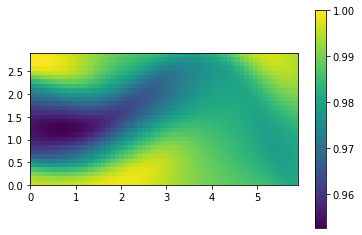

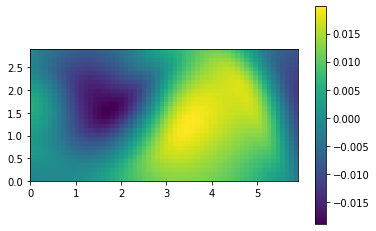

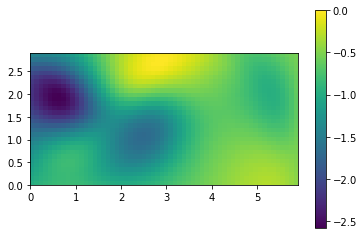

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def trim_data(u_data, x_min, x_max, y_min, y_max):
    """
    u_data : shape nx,ny,t
    """
    return u_data[y_min:y_max, x_min:x_max, :]

x_min = 40
x_max = 100
y_min = 10
y_max = 40

# CFD data
dx = 0.1
dy = 0.1
cfl = 0.2
dt = cfl*dx

# Load Data
CFD_DATAPATH = '/content/drive/My Drive/研究/PINN_with_BC/data_by_cfd/'
u_data = np.load(CFD_DATAPATH + 'u.npy') # (t,x,y)
print("vel shape", u_data.shape)
nt = u_data.shape[0]-1
print(f"all t step: {nt}")
# 時刻選択
T=75
# 0からntをT分割
idx_t = np.linspace(0, nt, T, dtype=int)
print("idxt: ", idx_t.shape)

# idx_t = np.arange(0, nt//10)
print(f"time step : {idx_t.shape[0]}")
u_data = u_data[idx_t,:,:]
print("before", u_data.shape)
u_data = u_data.transpose(1,2,0) # ny*nx*t
print("after",u_data.shape)
u_data = trim_data(u_data, x_min, x_max, y_min, y_max)
ny, nx, nt = u_data.shape
u_data = u_data.reshape(nx*ny, nt)
u_data = u_data[:, None, :]

v_data = np.load(CFD_DATAPATH + 'v.npy')[idx_t,:,:].transpose(1,2,0) # nx*ny*t
v_data = trim_data(v_data, x_min, x_max, y_min, y_max)
v_data = v_data.reshape(-1, nt)
v_data = v_data[:, None, :]

assert u_data.shape == v_data.shape, "hoge" 

p_data = np.load(CFD_DATAPATH + "p.npy")
p_data = p_data[idx_t,:,:].transpose(1,2,0)
p_data = trim_data(p_data, x_min, x_max, y_min, y_max)
p_data = p_data.reshape(nx*ny, nt)
print(u_data.shape)
print(idx_t.shape)

X = np.arange(0, nx*dx, dx)
X_index = np.arange(0, nx, 1)
Y = np.arange(0, ny*dy, dy)
Y_index = np.arange(0, ny, 1)

X_data, Y_data = np.meshgrid(X, Y) # nx * ny
x_data = X_data.flatten()[:,None] # N, 1
y_data = Y_data.flatten()[:,None] # N, 1

# dataのshapeを統一させる
# U_star N*2*T
# P_star N*T
# t_star T
# X_star N*2
U_star = np.concatenate([u_data, v_data], axis=1)
P_star = p_data
t_star = idx_t*dt
X_star = np.concatenate([x_data, y_data], axis=1)
print(t_star.shape)

## ここから同じ

u_data = U_star[:,0,:].reshape([Y.shape[0], X.shape[0], t_star.shape[0]])
v_data = U_star[:,1,:].reshape([Y.shape[0], X.shape[0], t_star.shape[0]])
p_data = P_star.reshape([Y.shape[0], X.shape[0], t_star.shape[0]])


save_anim(u_data, t_star, f_out="u_input")
save_anim(v_data, t_star, f_out="v_input")
save_anim(p_data, t_star, f_out="p_input")

(5000, 2, 200)
(100,)
(50,)
(200, 1)


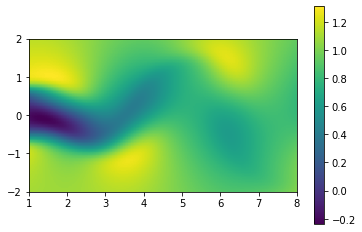

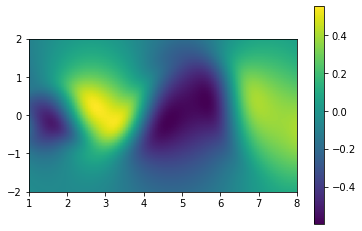

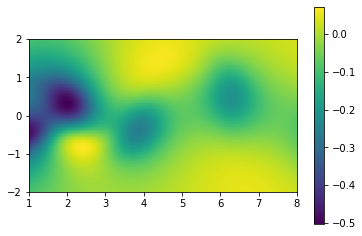

In [0]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load Data
data_path = "/content/drive/My Drive/研究/PINN_with_BC/data/cylinder_nektar_wake.mat"
data = scipy.io.loadmat(data_path)

# 訓練データの取得
U_star = data['U_star'] # N x 2 x T
print(U_star.shape)
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

X = np.unique(X_star[:,0])
print(X.shape)
Y = np.unique(X_star[:,1])
print(Y.shape)
#P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
# t_star = np.arange(0, 10, 0.1).reshape(-1,1)
print(t_star.shape)

## ここから同じ

u_data = U_star[:,0,:].reshape([Y.shape[0], X.shape[0], t_star.shape[0]])
v_data = U_star[:,1,:].reshape([Y.shape[0], X.shape[0], t_star.shape[0]])
p_data = P_star.reshape([Y.shape[0], X.shape[0], t_star.shape[0]])

save_anim(u_data, t_star, f_out="u_input_aim")
save_anim(v_data, t_star, f_out="v_input_aim")
save_anim(p_data, t_star, f_out="p_input_aim")

In [0]:
class Training(object):
    def __init__(self, U_star, P_star, t_star, X_star):
        # 訓練データの取得
        self.U_star = U_star
        self.P_star = P_star
        self.t_star = t_star
        self.X_star = X_star
    
        self.preprocess()

        self.model = PhysicsInformedNN(self.x0, self.y0, self.t0, self.u0, self.v0,
                    self.xb, self.yb, self.tb, self.ub, self.vb,
                    self.x_train, self.y_train, self.t_train,
                    layers= [3, 20, 20, 20, 20, 20, 20, 2],
                    p0=None, pb=None)

    def preprocess(self):
        N = self.X_star.shape[0]
        print(f"N is {N}")
        T = self.t_star.shape[0]
        print(f"T is {T}")
        # Rearrange Data 
        XX = np.tile(self.X_star[:,0:1], (1,T)) # N x T
        YY = np.tile(self.X_star[:,1:2], (1,T)) # N x T
        TT = np.tile(self.t_star, (1,N)).T # N x T
        self.TT = TT

        print(XX)
        print(YY)
        print(TT)
        
        UU = self.U_star[:,0,:] # N x T
        VV = self.U_star[:,1,:] # N x T
        PP = self.P_star # N x T
        
        x = XX.flatten()[:,None] # NT x 1
        y = YY.flatten()[:,None] # NT x 1
        t = TT.flatten()[:,None] # NT x 1
        
        u = UU.flatten()[:,None] # NT x 1
        v = VV.flatten()[:,None] # NT x 1
        p = PP.flatten()[:,None] # NT x 1

        print(x,y,t)
        print(x.shape)

        ## 条件を課してindexを取得
        ## 条件を課してindexを取得
        is_IC = t==0
        is_BC_left = x==x.min()
        is_BC_right = x==x.max()
        is_BC_bot = y==y.min()
        is_BC_top = y==y.max()
        is_BC = is_BC_left|is_BC_right|is_BC_bot|is_BC_top
        is_condition = is_IC|is_BC
        idx_condition = np.where(is_condition)[0]
        
        # 初期条件
        self.x0 = x[is_IC].reshape(-1,1)
        self.y0 = y[is_IC].reshape(-1,1)
        self.t0 = t[is_IC].reshape(-1,1)
        self.u0 = u[is_IC].reshape(-1,1)
        self.v0 = v[is_IC].reshape(-1,1)
        self.p0 = p[is_IC].reshape(-1,1)

        # 境界条件
        self.xb = x[is_BC].reshape(-1,1)
        self.yb = y[is_BC].reshape(-1,1)
        self.tb = t[is_BC].reshape(-1,1)
        self.ub = u[is_BC].reshape(-1,1)
        self.vb = v[is_BC].reshape(-1,1)
        self.pb = p[is_BC].reshape(-1,1)

        # Training Data
        N_train = 10000
        idx = np.random.choice(N*T, N_train, replace=False)
        self.x_train = x[idx,:]
        self.y_train = y[idx,:]
        self.t_train = t[idx,:]

    def train(self, epoch):
        self.model.train(epoch)

    def predict_plot_snap(self, snap):
        print("snap time is : ", int(self.t_star[snap]))
        snap = np.array([snap]) # hoge
        x_star = self.X_star[:,0:1]
        y_star = self.X_star[:,1:2]
        t_star = self.TT[:,snap]
    
        u_star = self.U_star[:,0,snap]
        v_star = self.U_star[:,1,snap]
        p_star = self.P_star[:,snap]
    
        # Prediction
        u_pred, v_pred, p_pred = self.model.predict(x_star, y_star, t_star)
        print("t shape {}".format(t_star.shape))
        print("u shape {}".format(u_pred.shape))
        print("p shape {}".format(p_pred.shape))

        # Error
        error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
        error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
        error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
    
        print('Error u: %e' % (error_u))    
        print('Error v: %e' % (error_v))    
        print('Error p: %e' % (error_p))                     
    
        # Plot Results
        plot_solution(self.X_star, u_pred, 1, f_out="u_pred")
        plot_solution(self.X_star, u_star, 2, f_out="u_true")
        plot_solution(self.X_star, v_pred, 3, f_out="v_pred")
        plot_solution(self.X_star, v_star, 4, f_out="v_true")
        plot_solution(self.X_star, p_pred, 5, f_out="p_pred")    
        plot_solution(self.X_star, p_star, 6, f_out="p_ture")
        plot_solution(self.X_star, np.abs(u_star - u_pred), 7, f_out="u_err")
        plot_solution(self.X_star, np.abs(v_star - v_pred), 8, f_out="v_err")
        plot_solution(self.X_star, np.abs(p_star - p_pred), 9, f_out="p_err")

In [18]:
def trim_data(u_data, x_min, x_max, y_min, y_max):
    """
    u_data : shape nx,ny,t
    """
    return u_data[y_min:y_max, x_min:x_max, :]

x_min = 40
x_max = 100
y_min = 10
y_max = 40

# CFD data
dx = 0.1
dy = 0.1
cfl = 0.2
dt = cfl*dx

# Load Data
CFD_DATAPATH = '/content/drive/My Drive/研究/PINN_with_BC/data_by_cfd/'
u_data = np.load(CFD_DATAPATH + 'u.npy') # (t,x,y)
print("vel shape", u_data.shape)
nt = u_data.shape[0]-1
print(f"all t step: {nt}")
# 時刻選択
T=200
# 0からntをT分割
idx_t = np.linspace(0, nt, T, dtype=int)
idx_t = idx_t[5:]
print("idxt: ", idx_t.shape)

# idx_t = np.arange(0, nt//10)
print(f"time step : {idx_t.shape[0]}")
u_data = u_data[idx_t,:,:]
print("before", u_data.shape)
u_data = u_data.transpose(1,2,0) # ny*nx*t
print("after",u_data.shape)
u_data = trim_data(u_data, x_min, x_max, y_min, y_max)
ny, nx, nt = u_data.shape
u_data = u_data.reshape(nx*ny, nt)
u_data = u_data[:, None, :]

v_data = np.load(CFD_DATAPATH + 'v.npy')[idx_t,:,:].transpose(1,2,0) # nx*ny*t
v_data = trim_data(v_data, x_min, x_max, y_min, y_max)
v_data = v_data.reshape(-1, nt)
v_data = v_data[:, None, :]

assert u_data.shape == v_data.shape, "hoge" 

p_data = np.load(CFD_DATAPATH + "p.npy")
p_data = p_data[idx_t,:,:].transpose(1,2,0)
p_data = trim_data(p_data, x_min, x_max, y_min, y_max)
p_data = p_data.reshape(nx*ny, nt)
print(u_data.shape)
print(idx_t.shape)

X = np.arange(0, nx*dx, dx)
X_index = np.arange(0, nx, 1)
Y = np.arange(0, ny*dy, dy)
Y_index = np.arange(0, ny, 1)

X_data, Y_data = np.meshgrid(X, Y) # nx * ny
x_data = X_data.flatten()[:,None] # N, 1
y_data = Y_data.flatten()[:,None] # N, 1

# dataのshapeを統一させる
# U_star N*2*T
# P_star N*T
# t_star T
# X_star N*2
U_star = np.concatenate([u_data, v_data], axis=1)
P_star = p_data
t_star = idx_t*dt
X_star = np.concatenate([x_data, y_data], axis=1)
print(t_star.shape)

training = Training(U_star, P_star, t_star, X_star)
training.train(1000)

vel shape (10001, 51, 101)
all t step: 10000
idxt:  (195,)
time step : 195
before (195, 51, 101)
after (51, 101, 195)
(1800, 1, 195)
(195,)
(195,)
N is 1800
T is 195
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.2 0.2 0.2 ... 0.2 0.2 0.2]
 ...
 [5.7 5.7 5.7 ... 5.7 5.7 5.7]
 [5.8 5.8 5.8 ... 5.8 5.8 5.8]
 [5.9 5.9 5.9 ... 5.9 5.9 5.9]]
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]]
[[  5.02]
 [  6.02]
 [  7.02]
 ...
 [197.98]
 [198.98]
 [200.  ]]
[[0. ]
 [0. ]
 [0. ]
 ...
 [5.9]
 [5.9]
 [5.9]] [[0. ]
 [0. ]
 [0. ]
 ...
 [2.9]
 [2.9]
 [2.9]] [[  5.02]
 [  6.02]
 [  7.02]
 ...
 [197.98]
 [198.98]
 [200.  ]]
(351000, 1)
(1500, 3)
(0, 3)
(34320, 3)
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/r

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x7fc45e19a358>>
Traceback (most recent call last):
  File "/tensorflow-1.15.2/python3.6/tensorflow_core/python/client/session.py", line 755, in __del__
    def __del__(self):
KeyboardInterrupt: 


KeyboardInterrupt: ignored

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: ignored

In [0]:

# ## CFD用
# # datapath(dir)
# CFD_DATAPATH = '/content/drive/My Drive/研究/PINN_with_BC/data_by_cfd/'

# # layer定義(fc)
# layers = [3, 20, 20, 20, 20, 20, 20, 2]

# T = 500 # Constant

# # 切り取りする
# x_min = 40
# x_max = 100
# y_min = 10
# y_max = 40

# # CFD data
# dx = 0.1
# dy = 0.1
# cfl = 0.2
# dt = cfl*dx

# # Load Data
# u_data = np.load(CFD_DATAPATH + 'u.npy')
# nt = u_data.shape[0]-1
# idx_t = np.linspace(0, nt, T, dtype=int)
# # idx_t = np.arange(0, nt//5)
# start_idx = 100
# idx_t = idx_t[start_idx:]

# print(idx_t.shape)

# u_data = u_data[idx_t,:,:].transpose(2,1,0) # nx*ny*t
# u_data = trim_data(u_data, x_min, x_max, y_min, y_max)
# u_data_flatten = u_data.flatten()[:,None]
# v_data = np.load(CFD_DATAPATH + 'v.npy')[idx_t,:,:].transpose(2,1,0) # nx*ny*t
# v_data = trim_data(v_data, x_min, x_max, y_min, y_max)
# v_data_flatten = v_data.flatten()[:,None]
# assert u_data.shape == v_data.shape, "hoge"
# print(u_data.shape)
# UU_init = u_data[:,:,start_idx]
# VV_init = v_data[:,:,start_idx]
# nx, ny = UU_init.shape
# print(f"shape : {UU_init.shape}")

# X = np.arange(0, nx*dx, dx)
# X_index = np.arange(0, nx, 1)
# Y = np.arange(0, ny*dy, dy)
# Y_index = np.arange(0, ny, 1)
# idx_min = idx_t.min()
# t_star = ((idx_t-idx_min)*dt).reshape(-1,1)
# print(X)
# print(t_star.shape)

# _XX, _YY = np.meshgrid(X, Y) # nx * ny
# _XX = _XX.flatten()[:,None] # N, 1
# _YY = _YY.flatten()[:,None] # N, 1
# _XX_index, _YY_index = np.meshgrid(X_index, Y_index)
# _XX_index = _XX_index.flatten()[:, None]
# _YY_index = _YY_index.flatten()[:, None]

# N = _XX.shape[0]
# T = t_star.shape[0]

# # Rearrange Data 
# XX = np.tile(_XX, (1,T)) # N x T
# print("x shape : ", XX.shape)
# XX_index = np.tile(_XX_index, (1,T)) # N * T
# YY = np.tile(_YY, (1,T)) # N x T
# YY_index = np.tile(_YY_index, (1,T)) # N * T
# TT = np.tile(t_star, (1,N)).T # N x T
# print("t shape :", TT.shape)

# print(XX)
# print(YY)
# print(TT)

# x = XX.flatten()[:,None] # NT x 1
# print("x flat : ", x.shape)
# x_index = XX_index.flatten()[:,None] # NT * 1
# y = YY.flatten()[:,None] # NT x 1
# y_index = YY_index.flatten()[:,None] # NT * 1
# t = TT.flatten()[:,None] # NT x 1

# # 求めるパラメータ
# u = np.zeros_like(x)
# v = np.zeros_like(y)
# p = np.zeros_like(u)

# ## 条件を課してindexを取得
# is_IC = t==t.min()
# is_BC_left = x==x.min()
# is_BC_right = x==x.max()
# is_BC_bot = y==y.min()
# is_BC_top = y==y.max()
# is_BC = is_BC_left|is_BC_right|is_BC_bot|is_BC_top ## 付け加えること可能

# print("IC", is_IC.shape)
# print("BC",is_BC.shape)


# ## 初期条件
# x0 = x[is_IC].reshape(-1,1)
# y0 = y[is_IC].reshape(-1,1)
# t0 = t[is_IC].reshape(-1,1)
# u0 = UU_init.flatten()[:, None]
# v0 = VV_init.flatten()[:, None]
# print("x0 u0",x0.shape, u0.shape)

# ## 境界条件
# xb = x[is_BC].reshape(-1,1)
# yb = y[is_BC].reshape(-1,1)
# tb = t[is_BC].reshape(-1,1)
# ub = u_data_flatten[is_BC].reshape(-1,1)
# vb = v_data_flatten[is_BC].reshape(-1,1)
# # u[is_block] = 0.
# # v[is_block] = 0.

# raise NotImplemented

# ######################################################################
# ######################## Noiseles Data ###############################
# ######################################################################
# # Training Data
# N_train = 500
# idx = np.random.choice(N*T, N_train, replace=False)
# x_train = x[idx, :]
# y_train = y[idx, :]
# t_train = t[idx, :]

# # Training
# model = PhysicsInformedNN(x0, y0, t0, u0, v0,
#                  xb, yb, tb, ub, vb,
#                  x_train, y_train, t_train,
#                  layers)
# epoch = 1000
# model.train(epoch)

# iterations = np.arange(len(model.loss_list))
# plt.plot(iterations, model.loss_list)
# plt.savefig("/content/drive/My Drive/研究/PINN_with_BC/output/loss.png")
# plt.show()
# # Test Data
# snap = np.array([50])
# x_star = _XX.reshape(-1,1)
# y_star = _YY.reshape(-1,1)
# t_star = TT[:,snap]

# # u_star = U_star[:,0,snap]
# # v_star = U_star[:,1,snap]
# # p_star = P_star[:,snap]

# # Prediction
# u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
# print("t shape {}".format(t_star.shape))
# print("u shape {}".format(u_pred.shape))
# print("p shape {}".format(p_pred.shape))

# # Error
# # error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
# # error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
# # error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)

# # print('Error u: %e' % (error_u))    
# # print('Error v: %e' % (error_v))    
# # print('Error p: %e' % (error_p))                     

# # Plot Results
# X_star = np.concatenate([x_star, y_star], axis=1)
# plot_solution(X_star, u_pred, 1)
# plot_solution(X_star, v_pred, 2)
# plot_solution(X_star, p_pred, 3)    
# # plot_solution(X_star, p_star, 4)
# # plot_solution(X_star, p_star - p_pred, 5)


(400,)
(60, 30, 400)
shape : (60, 30)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9]
(400, 1)
x shape :  (1800, 400)
t shape : (1800, 400)
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.1 0.1 0.1 ... 0.1 0.1 0.1]
 [0.2 0.2 0.2 ... 0.2 0.2 0.2]
 ...
 [5.7 5.7 5.7 ... 5.7 5.7 5.7]
 [5.8 5.8 5.8 ... 5.8 5.8 5.8]
 [5.9 5.9 5.9 ... 5.9 5.9 5.9]]
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]
 [2.9 2.9 2.9 ... 2.9 2.9 2.9]]
[[  0.     0.4    0.8  ... 159.1  159.5  159.92]
 [  0.     0.4    0.8  ... 159.1  159.5  159.92]
 [  0.     0.4    0.8  ... 159.1  159.5  159.92]
 ...
 [  0.     0.4    0.8  ... 159.1  159.5  159.92]
 [  0.     0.4    0.8  ... 159.1  159.5  159.92]
 [  0.     0.4    0.8  ... 15

TypeError: ignored

ストリーミング出力は最後の 5000 行に切り捨てられました。
Loss: 2.399e-02
Loss: 2.397e-02
Loss: 2.395e-02
Loss: 2.393e-02
Loss: 2.390e-02
Loss: 2.388e-02
Loss: 2.386e-02
Loss: 2.383e-02
Loss: 2.381e-02
Loss: 2.378e-02
Loss: 2.377e-02
Loss: 2.375e-02
Loss: 2.374e-02
Loss: 2.372e-02
Loss: 2.371e-02
Loss: 2.369e-02
Loss: 2.366e-02
Loss: 2.364e-02
Loss: 2.362e-02
Loss: 2.360e-02
Loss: 2.359e-02
Loss: 2.357e-02
Loss: 2.357e-02
Loss: 2.355e-02
Loss: 2.352e-02
Loss: 2.350e-02
Loss: 2.347e-02
Loss: 2.344e-02
Loss: 2.340e-02
Loss: 2.337e-02
Loss: 2.335e-02
Loss: 2.332e-02
Loss: 2.328e-02
Loss: 2.325e-02
Loss: 2.323e-02
Loss: 2.322e-02
Loss: 2.320e-02
Loss: 2.318e-02
Loss: 2.316e-02
Loss: 2.315e-02
Loss: 2.313e-02
Loss: 2.311e-02
Loss: 2.308e-02
Loss: 2.307e-02
Loss: 2.303e-02
Loss: 2.301e-02
Loss: 2.299e-02
Loss: 2.297e-02
Loss: 2.303e-02
Loss: 2.296e-02
Loss: 2.293e-02
Loss: 2.291e-02
Loss: 2.289e-02
Loss: 2.287e-02
Loss: 2.285e-02
Loss: 2.283e-02
Loss: 2.282e-02
Loss: 2.281e-02
Loss: 2.279e-02
Loss: 2.278e-02
Loss: 2.

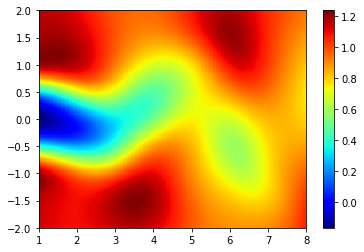

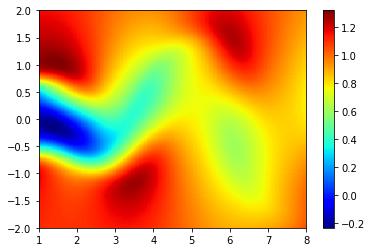

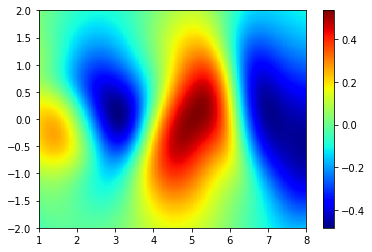

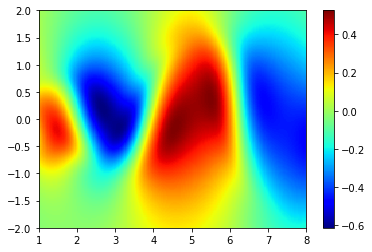

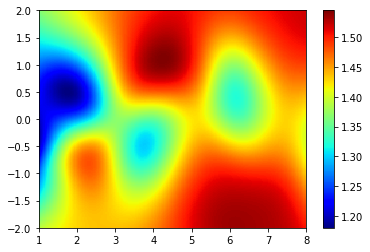

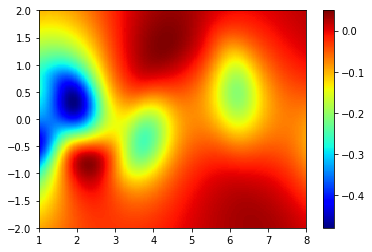

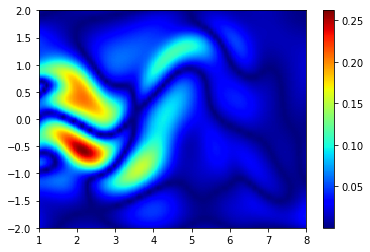

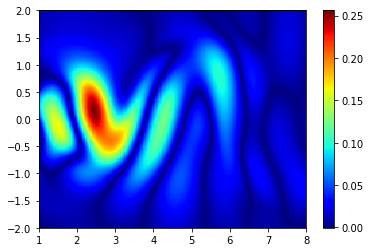

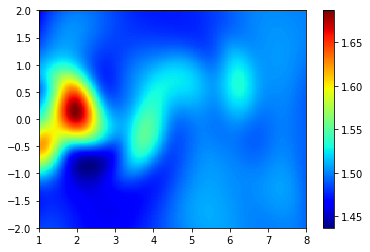

In [34]:
# Load Data
data_path = "/content/drive/My Drive/研究/PINN_with_BC/data/cylinder_nektar_wake.mat"
data = scipy.io.loadmat(data_path)

# 訓練データの取得
U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # T x 1
X_star = data['X_star'] # N x 2

training = Training(U_star, P_star, t_star, X_star)
training.train(1500)
training.predict_plot_snap(50)

In [0]:
if __name__ == "__main__": 
    
    # 訓練データ数
    N_train = 500
    
    # layer定義(fc)
    layers = [3, 20, 20, 20, 20, 20, 20, 2]
    
    # Load Data
    data_path = "/content/drive/My Drive/研究/PINN_with_BC/data/cylinder_nektar_wake.mat"
    data = scipy.io.loadmat(data_path)

    # 訓練データの取得
    U_star = data['U_star'] # N x 2 x T
    P_star = data['p_star'] # N x T
    t_star = data['t'] # T x 1
    X_star = data['X_star'] # N x 2
    
    N = X_star.shape[0]
    print(f"N is {N}")
    T = t_star.shape[0]
    print(f"T is {T}")
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T
    TT = np.tile(t_star, (1,N)).T # N x T

    print(XX)
    print(YY)
    print(TT)
    
    UU = U_star[:,0,:] # N x T
    VV = U_star[:,1,:] # N x T
    PP = P_star # N x T
    
    x = XX.flatten()[:,None] # NT x 1
    y = YY.flatten()[:,None] # NT x 1
    t = TT.flatten()[:,None] # NT x 1
    
    u = UU.flatten()[:,None] # NT x 1
    v = VV.flatten()[:,None] # NT x 1
    p = PP.flatten()[:,None] # NT x 1

    print(x,y,t)
    print(x.shape)

    ## 条件を課してindexを取得
    ## 条件を課してindexを取得
    is_IC = t==0
    is_BC_left = x==x.min()
    is_BC_right = x==x.max()
    is_BC_bot = y==y.min()
    is_BC_top = y==y.max()
    is_BC = is_BC_left|is_BC_right|is_BC_bot|is_BC_top
    is_condition = is_IC|is_BC
    idx_condition = np.where(is_condition)[0]
    
    # 初期条件
    x0 = x[is_IC].reshape(-1,1)
    y0 = y[is_IC].reshape(-1,1)
    t0 = t[is_IC].reshape(-1,1)
    u0 = u[is_IC].reshape(-1,1)
    v0 = v[is_IC].reshape(-1,1)

    # 境界条件
    xb = x[is_BC].reshape(-1,1)
    yb = y[is_BC].reshape(-1,1)
    tb = t[is_BC].reshape(-1,1)
    ub = u[is_BC].reshape(-1,1)
    vb = v[is_BC].reshape(-1,1)

    raise NotImplemented


    ######################################################################
    ######################## Noiseles Data ###############################
    ######################################################################
    # Training Data
    idx = np.random.choice(N*T, N_train, replace=False)
    x_train = x[idx,:]
    y_train = y[idx,:]
    t_train = t[idx,:]
    # u_train = u[idx_condition,:]
    # v_train = v[idx_condition,:]

    # Training
    model = PhysicsInformedNN(x0, y0, t0, u0, v0,
                 xb, yb, tb, ub, vb,
                 x_train, y_train, t_train,
                 layers)
    epoch = 1000
    model.train(epoch)
    
    iterations = np.arange(len(model.loss_list))
    plt.plot(iterations, model.loss_list)
    plt.savefig("/content/drive/My Drive/研究/PINN_with_BC/output/loss_aim.png")
    plt.show()

    # Test Data
    snap = np.array([100])
    x_star = X_star[:,0:1]
    y_star = X_star[:,1:2]
    t_star = TT[:,snap]
    
    u_star = U_star[:,0,snap]
    v_star = U_star[:,1,snap]
    p_star = P_star[:,snap]
    
    # Prediction
    u_pred, v_pred, p_pred = model.predict(x_star, y_star, t_star)
    print("t shape {}".format(t_star.shape))
    print("u shape {}".format(u_pred.shape))
    print("p shape {}".format(p_pred.shape))

    # Error
    error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
    error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
    
    print('Error u: %e' % (error_u))    
    print('Error v: %e' % (error_v))    
    print('Error p: %e' % (error_p))                     
    
    # Plot Results
    plot_solution(X_star, u_pred, 1)
    plot_solution(X_star, v_pred, 2)
    plot_solution(X_star, p_pred, 3)    
    plot_solution(X_star, p_star, 4)
    plot_solution(X_star, p_star - p_pred, 5)
    
    # Predict for plotting
    lb = X_star.min(0)
    ub = X_star.max(0)
    nn = 200
    x = np.linspace(lb[0], ub[0], nn)
    y = np.linspace(lb[1], ub[1], nn)
    X, Y = np.meshgrid(x,y)
    
    UU_star = griddata(X_star, u_pred.flatten(), (X, Y), method='cubic')
    VV_star = griddata(X_star, v_pred.flatten(), (X, Y), method='cubic')
    PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')
    P_exact = griddata(X_star, p_star.flatten(), (X, Y), method='cubic')
    
    ######################################################################
    ########################### Noisy Data ###############################
    ######################################################################
    # noise = 0.01        
    # u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
    # v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])    

    # # Training
    # model = PhysicsInformedNN(x_train, y_train, t_train, u_train, v_train, idx, layers)
    # model.train(2000)
        
    # lambda_1_value_noisy = model.sess.run(model.lambda_1)
    # lambda_2_value_noisy = model.sess.run(model.lambda_2)
      
    # error_lambda_1_noisy = np.abs(lambda_1_value_noisy - 1.0)*100
    # error_lambda_2_noisy = np.abs(lambda_2_value_noisy - 0.01)/0.01 * 100
        
    # print('Error l1: %.5f%%' % (error_lambda_1_noisy))                             
    # print('Error l2: %.5f%%' % (error_lambda_2_noisy))     

             
    
    ######################################################################
    ############################# Plotting ###############################
    ######################################################################    
     # Load Data
    # data_vort = scipy.io.loadmat(data_path)
           
    # x_vort = data_vort['x'] 
    # y_vort = data_vort['y'] 
    # w_vort = data_vort['w'] 
    # modes = np.asscalar(data_vort['modes'])
    # nel = np.asscalar(data_vort['nel'])    
    
    # xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
    # yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
    # ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')
    
    # box_lb = np.array([1.0, -2.0])
    # box_ub = np.array([8.0, 2.0])
    
    # fig, ax = newfig(1.0, 1.2)
    # ax.axis('off')
    
    # ####### Row 0: Vorticity ##################    
    # gs0 = gridspec.GridSpec(1, 2)
    # gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
    # ax = plt.subplot(gs0[:, :])
    
    # for i in range(0, nel):
    #     h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3) 
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # fig.colorbar(h, cax=cax)
    
    # ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    # ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
    # ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
    # ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)
    
    # ax.set_aspect('equal', 'box')
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    # ax.set_title('Vorticity', fontsize = 10)
    
    
    # ####### Row 1: Training data ##################
    # ########      u(t,x,y)     ###################        
    # gs1 = gridspec.GridSpec(1, 2)
    # gs1.update(top=1-2/4, bottom=0.0, left=0.01, right=0.99, wspace=0)
    # ax = plt.subplot(gs1[:, 0],  projection='3d')
    # ax.axis('off')

    # r1 = [x_star.min(), x_star.max()]
    # r2 = [data['t'].min(), data['t'].max()]       
    # r3 = [y_star.min(), y_star.max()]
    
    # for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    #     if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
    #         ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    # ax.scatter(x_train, t_train, y_train, s = 0.1)
    # ax.contourf(X,UU_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    # ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    # ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    # ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    # ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$u(t,x,y)$')    
    # ax.set_xlim3d(r1)
    # ax.set_ylim3d(r2)
    # ax.set_zlim3d(r3)
    # axisEqual3D(ax)
    
    # ########      v(t,x,y)     ###################        
    # ax = plt.subplot(gs1[:, 1],  projection='3d')
    # ax.axis('off')
    
    # r1 = [x_star.min(), x_star.max()]
    # r2 = [data['t'].min(), data['t'].max()]       
    # r3 = [y_star.min(), y_star.max()]
    
    # for s, e in combinations(np.array(list(product(r1,r2,r3))), 2):
    #     if np.sum(np.abs(s-e)) == r1[1]-r1[0] or np.sum(np.abs(s-e)) == r2[1]-r2[0] or np.sum(np.abs(s-e)) == r3[1]-r3[0]:
    #         ax.plot3D(*zip(s,e), color="k", linewidth = 0.5)   

    # ax.scatter(x_train, t_train, y_train, s = 0.1)
    # ax.contourf(X,VV_star,Y, zdir = 'y', offset = t_star.mean(), cmap='rainbow', alpha = 0.8)
              
    # ax.text(x_star.mean(), data['t'].min() - 1, y_star.min() - 1, '$x$')
    # ax.text(x_star.max()+1, data['t'].mean(), y_star.min() - 1, '$t$')
    # ax.text(x_star.min()-1, data['t'].min() - 0.5, y_star.mean(), '$y$')
    # ax.text(x_star.min()-3, data['t'].mean(), y_star.max() + 1, '$v(t,x,y)$')    
    # ax.set_xlim3d(r1)
    # ax.set_ylim3d(r2)
    # ax.set_zlim3d(r3)
    # axisEqual3D(ax)
    
    # # savefig('./figures/NavierStokes_data') 

    
    # fig, ax = newfig(1.015, 0.8)
    # ax.axis('off')
    
    # ######## Row 2: Pressure #######################
    # ########      Predicted p(t,x,y)     ########### 
    # gs2 = gridspec.GridSpec(1, 2)
    # gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
    # ax = plt.subplot(gs2[:, 0])
    # h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow', 
    #               extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
    #               origin='lower', aspect='auto')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)

    # fig.colorbar(h, cax=cax)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    # ax.set_aspect('equal', 'box')
    # ax.set_title('Predicted pressure', fontsize = 10)
    
    # ########     Exact p(t,x,y)     ########### 
    # ax = plt.subplot(gs2[:, 1])
    # h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
    #               extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
    #               origin='lower', aspect='auto')
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)

    # fig.colorbar(h, cax=cax)
    # ax.set_xlabel('$x$')
    # ax.set_ylabel('$y$')
    # ax.set_aspect('equal', 'box')
    # ax.set_title('Exact pressure', fontsize = 10)
    
    
    # ######## Row 3: Table #######################
    # gs3 = gridspec.GridSpec(1, 2)
    # gs3.update(top=1-1/2, bottom=0.0, left=0.0, right=1.0, wspace=0)
    # ax = plt.subplot(gs3[:, :])
    # ax.axis('off')
    
    # s = r'$\begin{tabular}{|c|c|}';
    # s = s + r' \hline'
    # s = s + r' Correct PDE & $\begin{array}{c}'
    # s = s + r' u_t + (u u_x + v u_y) = -p_x + 0.01 (u_{xx} + u_{yy})\\'
    # s = s + r' v_t + (u v_x + v v_y) = -p_y + 0.01 (v_{xx} + v_{yy})'
    # s = s + r' \end{array}$ \\ '
    # s = s + r' \hline'
    # s = s + r' Identified PDE (clean data) & $\begin{array}{c}'
    # s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value, lambda_2_value)
    # s = s + r' \\'
    # s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value, lambda_2_value)
    # s = s + r' \end{array}$ \\ '
    # s = s + r' \hline'
    # s = s + r' Identified PDE (1\% noise) & $\begin{array}{c}'
    # s = s + r' u_t + %.3f (u u_x + v u_y) = -p_x + %.5f (u_{xx} + u_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    # s = s + r' \\'
    # s = s + r' v_t + %.3f (u v_x + v v_y) = -p_y + %.5f (v_{xx} + v_{yy})' % (lambda_1_value_noisy, lambda_2_value_noisy)
    # s = s + r' \end{array}$ \\ '
    # s = s + r' \hline'
    # s = s + r' \end{tabular}$'
 
    # ax.text(0.015,0.0,s)
    
    # # savefig('./figures/NavierStokes_prediction') 

N is 5000
T is 200
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.07070707 1.07070707 1.07070707 ... 1.07070707 1.07070707 1.07070707]
 [1.14141414 1.14141414 1.14141414 ... 1.14141414 1.14141414 1.14141414]
 ...
 [7.85858586 7.85858586 7.85858586 ... 7.85858586 7.85858586 7.85858586]
 [7.92929293 7.92929293 7.92929293 ... 7.92929293 7.92929293 7.92929293]
 [8.         8.         8.         ... 8.         8.         8.        ]]
[[-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 [-2. -2. -2. ... -2. -2. -2.]
 ...
 [ 2.  2.  2. ...  2.  2.  2.]
 [ 2.  2.  2. ...  2.  2.  2.]
 [ 2.  2.  2. ...  2.  2.  2.]]
[[ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 ...
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]
 [ 0.   0.1  0.2 ... 19.7 19.8 19.9]]
[[1.]
 [1.]
 [1.]
 ...
 [8.]
 [8.]
 [8.]] [[-2.]
 [-2.]
 [-2.]
 ...
 [ 2.]
 [ 2.]
 [ 2.]] [[ 0. ]
 [ 0.1]
 [ 0.2]
 ..

TypeError: ignored

x方向の格子数:60
y方向の格子数:30


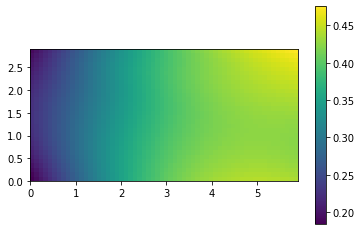

In [0]:
# plot for CFD
# Test Data
snap = np.arange(50)
X = np.unique(X_star[:,0])
n_X = X.shape[0]
print("x方向の格子数:{}".format(n_X))
Y = np.unique(X_star[:,1])
n_Y = Y.shape[0]
print("y方向の格子数:{}".format(n_Y))
# t_star = TT[:,snap]
N = n_X*n_Y
TT = np.tile(t_star, (1,N)).T # N x T
t_star = TT
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
# u_star = U_star[:,0,snap]
# v_star = U_star[:,1,snap]
# p_star = P_star[:,snap]
    
# Prediction

    
ims = []
fig, ax = plt.subplots()
for i in range(0, 100):
    t = t_star[:,i].reshape(-1,1)
    #print(t.shape)
    u_pred, v_pred, p_pred = training.model.predict(x_star, y_star, t)
    #print("t shape {}".format(t_star.shape))
    #print("u shape {}".format(u_pred.shape))
    #print("p shape {}".format(p_pred.shape))
    p = p_pred
    #print(p.shape) (5000,1)
    p = p.reshape([n_Y, n_X]) #(100,50)
    im = ax.imshow(p, extent=[np.min(X), np.max(X),np.min(Y), np.max(Y)], animated=True)  # vmin,vmaxで等高線のカラーリングを調整

    if i == 0:  # 最初のループだけカラーバーをつける
        fig.colorbar(im, ax=ax)

    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=5, blit=True)
anim.save('/content/drive/My Drive/研究/PINN_with_BC/output/test_output.gif', writer="imagemagick") 
               

x方向の格子数:60
y方向の格子数:30


InvalidArgumentError: ignored

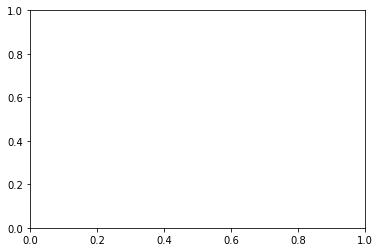

In [0]:
# Test Data
snap = np.arange(100)
X = np.unique(X_star[:,0])
n_X = X.shape[0]
print("x方向の格子数:{}".format(n_X))
Y = np.unique(X_star[:,1])
n_Y = Y.shape[0]
print("y方向の格子数:{}".format(n_Y))
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
TT = np.tile(t_star, (1,n_X*n_Y)).T # N x T
t_star = TT
    
# u_star = U_star[:,0,snap]
# v_star = U_star[:,1,snap]
# p_star = P_star[:,snap]
    
# Prediction

    
ims = []
fig, ax = plt.subplots()
for i in range(0, 100):
    t = t_star[:,i].reshape(-1,1)
    #print(t.shape)
    u_pred, v_pred, p_pred = training.model.predict(x_star, y_star, t)
    #print("t shape {}".format(t_star.shape))
    #print("u shape {}".format(u_pred.shape))
    #print("p shape {}".format(p_pred.shape))
    p = p_pred
    #print(p.shape) (5000,1)
    p = p.reshape([n_Y, n_X]) #(100,50)
    im = ax.imshow(p, extent=[np.min(X), np.max(X),np.min(Y), np.max(Y)], animated=True)  # vmin,vmaxで等高線のカラーリングを調整

    if i == 0:  # 最初のループだけカラーバーをつける
        fig.colorbar(im, ax=ax)

    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=5, blit=True)
anim.save('/content/drive/My Drive/研究/PINN_with_BC/output/test_output_aim.gif', writer="imagemagick") 
               
    